## MADlib Greenplum Demo
---

### Import neccessary Data Science libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 200)

Connect to Greenplum Database

In [2]:
%load_ext sql

In [3]:
!minikube service list

|-------------|------------------------------------------------------|--------------|------------------------------|
|  NAMESPACE  |                         NAME                         | TARGET PORT  |             URL              |
|-------------|------------------------------------------------------|--------------|------------------------------|
| default     | agent                                                | No node port |
| default     | greenplum                                            | psql/5432    | http://192.168.133.128:32000 |
| default     | greenplum-validating-webhook-service-9d44d9fcf-t26tq | No node port |
| default     | kubernetes                                           | No node port |
| default     | my-greenplum-pl                                      | No node port |
| default     | my-greenplum-pxf                                     | No node port |
| kube-system | kube-dns                                             | No node port |
|-------------|-

In [4]:
%sql postgresql://gpadmin@192.168.133.128:32000/db

/usr/local/anaconda3/envs/madlib/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


### Check Database Data

In [6]:
%%sql


SELECT COUNT(*) AS num_sample FROM sensors;

 * postgresql://gpadmin@192.168.133.128:32000/db
1 rows affected.


num_sample
200000


In [7]:
%%sql

SELECT * FROM sensors LIMIT 10;

 * postgresql://gpadmin@192.168.133.128:32000/db
10 rows affected.


timestamp,temperature,temperature_2,humidity,pm25
1997-03-22 00:00:00,30.6668585650253,42.9052858044298,69.2785492479998,73.1767528823951
1997-03-22 04:00:00,32.2240553161353,48.4451885030855,61.2088571248697,103.956207334568
1997-03-22 12:00:00,32.4185793403592,46.2930967363855,69.3046298170464,87.3012012853493
1997-03-22 20:00:00,31.6889779538602,50.3771697898689,53.2251690054103,76.757504341768
1997-03-22 21:00:00,31.414135143836,45.8292816079858,53.655786244688,77.837155684718
1997-03-22 22:00:00,31.5117735558417,49.7762550293786,31.5185341489772,98.0131261241892
1997-03-23 04:00:00,30.9732062825728,50.7305651158765,51.6463117699311,76.6613962119159
1997-03-23 06:00:00,31.1456715016839,50.5883567654865,50.6392021695488,77.1011145867884
1997-03-23 08:00:00,32.9173479628012,48.2255788669841,62.5489084902205,87.1120555127665
1997-03-23 12:00:00,32.5277304291036,47.7246721062276,15.1710744913787,91.5709933365243


In [8]:
sensors = %sql SELECT * FROM sensors LIMIT 1000;
sensors = sensors.DataFrame()

 * postgresql://gpadmin@192.168.133.128:32000/db
1000 rows affected.


In [9]:
sensors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      1000 non-null   datetime64[ns]
 1   temperature    1000 non-null   float64       
 2   temperature_2  1000 non-null   float64       
 3   humidity       1000 non-null   float64       
 4   pm25           1000 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 39.2 KB


In [10]:
sensors.describe()

,temperature,temperature_2,humidity,pm25
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,31.544820,46.594941,49.825028,89.652520
std,0.873392,3.145308,15.000050,14.299866
min,30.002098,34.493309,1.160944,38.564782
25%,30.826927,44.394214,39.490404,79.777687
50%,31.571728,46.469999,49.839717,89.727459
75%,32.317502,48.718686,60.158495,99.193445
max,32.998612,55.152494,93.333323,132.791284


/usr/local/anaconda3/envs/madlib/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


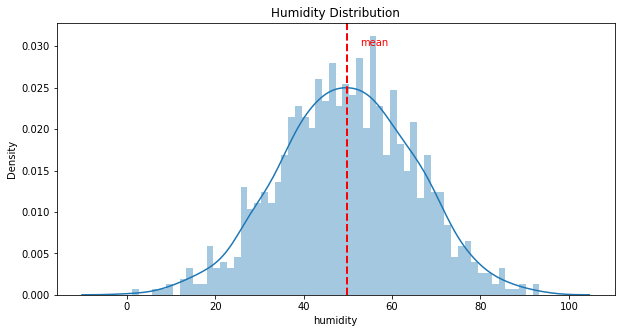

In [12]:
plt.figure(figsize=(10,5))
sns.distplot(sensors['humidity'],bins=60);
plt.title("Humidity Distribution")
plt.axvline(x=sensors['humidity'].mean(),color='red',ls='--',lw=2)
plt.text(sensors['humidity'].mean()+3,0.03, "mean", fontsize=10,c='red');

### Preprocess Data

Encode Month

```sql
CREATE FUNCTION parse_month(time_stamp timestamp)
  RETURNS char
AS $$
  from datetime import datetime
  date_obj=datetime.strptime(time_stamp,"%Y-%m-%d %H:%M:%S")
  return date_obj.strftime("%B")
$$ LANGUAGE plpythonu;
```

In [13]:
%%sql
SELECT *,parse_month(timestamp) FROM sensors WHERE pm25 > 160;

 * postgresql://gpadmin@192.168.133.128:32000/db
2 rows affected.


timestamp,temperature,temperature_2,humidity,pm25,parse_month
2014-11-23 21:00:00,30.8058720843154,42.7842327160495,44.8122950799332,161.947176404423,November
2015-04-16 22:00:00,33.0799518195087,50.5450234515165,40.0489227220552,161.772615888742,April


Create Month and rain Data

In [28]:
%%sql
DROP TABLE IF EXISTS sensors_pre;
CREATE TABLE sensors_pre
AS 
SELECT
    timestamp,
    temperature,
    temperature_2,
    humidity,
    pm25,
    parse_month(timestamp) AS month,           --- Month data
    CASE WHEN
            (humidity )>= 60
        THEN 1
        ELSE 0
    END as rain
FROM sensors;

SELECT * FROM sensors_pre LIMIT 10; 

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
200000 rows affected.
10 rows affected.


timestamp,temperature,temperature_2,humidity,pm25,month,rain
1997-03-22 00:00:00,30.6668585650253,42.9052858044298,69.2785492479998,73.1767528823951,March,1
1997-03-23 04:00:00,30.9732062825728,50.7305651158765,51.6463117699311,76.6613962119159,March,0
1997-03-23 06:00:00,31.1456715016839,50.5883567654865,50.6392021695488,77.1011145867884,March,0
1997-03-23 17:00:00,30.7293087213374,51.0992881844999,72.2276164814201,94.9085858990948,March,1
1997-03-24 19:00:00,30.954906770923,42.2946620832769,46.7073889033827,113.05207735578,March,0
1997-03-24 21:00:00,30.9957465357837,47.910602539389,45.1186145433521,77.4539783405741,March,0
1997-03-25 05:00:00,32.5626992437538,48.4174353253761,67.5519141589639,85.3148379298482,March,1
1997-03-25 17:00:00,32.7606167973364,43.5075620950977,27.108187864319,97.8867153820081,March,0
1997-03-25 20:00:00,30.9770378729866,49.1407151795,39.657734886977,76.1397638622327,March,0
1997-03-26 02:00:00,31.0098896785448,42.6752469286538,53.3649786920401,111.140679844686,March,0


In [29]:
%%sql
SELECT parse_month(timestamp) as month ,COUNT(*) as count  
    FROM sensors  
GROUP BY month ORDER BY count DESC;

 * postgresql://gpadmin@192.168.133.128:32000/db
12 rows affected.


month,count
December,17112
May,17112
August,17112
July,17112
October,17112
January,16688
March,16608
November,16560
June,16560
April,16560


### Encode categorical values

In [30]:
%%sql
DROP TABLE IF EXISTS sensors_encoded;


SELECT
madlib.encode_categorical_variables (
    'sensors_pre',
    'sensors_encoded',
    'month',
    NULL,  --categorical_cols_to_exclude     -- Optional
    NULL,  --row_id,                         -- Optional
    NULL,  --top,                            -- Optional
    NULL,  --value_to_drop,                  -- Optional
    NULL,  --encode_null,                    -- Optional
    NULL,  --output_type,                    -- Optional
    NULL,  --output_dictionary,              -- Optional
    NULL   --distributed_by                  -- Optional
);


SELECT * FROM sensors_encoded LIMIT 5;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
1 rows affected.
5 rows affected.


timestamp,temperature,temperature_2,humidity,pm25,rain,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
1997-03-23 04:00:00,30.9732062825728,50.7305651158765,51.6463117699311,76.6613962119159,0,0,0,0,0,0,0,0,1,0,0,0,0
1997-03-23 06:00:00,31.1456715016839,50.5883567654865,50.6392021695488,77.1011145867884,0,0,0,0,0,0,0,0,1,0,0,0,0
1997-03-24 21:00:00,30.9957465357837,47.910602539389,45.1186145433521,77.4539783405741,0,0,0,0,0,0,0,0,1,0,0,0,0
1997-03-27 02:00:00,32.1457076844318,45.6383118257931,49.3663153748771,98.7573827950472,0,0,0,0,0,0,0,0,1,0,0,0,0
1997-03-27 15:00:00,32.8470702255056,48.2737054126523,49.3894748062248,76.8431079775244,0,0,0,0,0,0,0,0,1,0,0,0,0


### EDA

In [31]:
%%sql
DROP TABLE IF EXISTS sensors_summary ;
SELECT madlib.summary (
    'sensors_encoded',  -- source_table
    'sensors_summary',  -- output_table
    NULL,  -- target_cols
    NULL,  -- grouping_cols
    TRUE,  -- get_distinct
    TRUE,  -- get_quartiles
    NULL,  -- quantile_array
    10,    -- how_many_mfv
    FALSE  -- get_estimate
);

SELECT * FROM sensors_summary LIMIT 5;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
1 rows affected.
5 rows affected.


group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,positive_values,negative_values,zero_values,mean,variance,confidence_interval,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
None,None,"""timestamp""",1,timestamp,200000,200000,0,None,0.0,None,None,None,None,None,None,None,None,None,None,None,None,"['2019-07-25 11:00:00', '2019-12-01 19:00:00', '2018-11-27 14:00:00', '2019-11-26 21:00:00', '2019-01-25 21:00:00', '2019-04-19 15:00:00', '2019-06-20 09:00:00', '2019-07-25 22:00:00', '2019-08-31 14:00:00', '2019-11-30 16:00:00']","[204, 203, 196, 196, 196, 196, 196, 195, 195, 195]"
None,None,temperature,2,float8,200000,200000,0,None,0.0,None,200000,0,0,32.0007889310936,0.833918535700296,"[31.9967866933154, 32.0047911688719]",30.0020976922364,33.9932399275613,31.2506718159847,32.0007082471155,32.7509473341128,"['31.3932971558727', '33.8444383302385', '31.5795452103724', '33.8818330236875', '31.0313808295486', '33.8943804292179', '32.6327097344443', '33.3490872942522', '33.9432526161229', '31.4823716656718']","[203, 200, 198, 197, 197, 196, 196, 195, 195, 195]"
None,None,temperature_2,3,float8,200000,200000,0,None,0.0,None,200000,0,0,46.99570081252,9.80804681581064,"[46.9819751809048, 47.0094264441353]",32.2943907804811,61.6835823795163,44.8807517740374,46.9961843733011,49.112212070946,"['42.8628249997972', '46.2961020468257', '42.9294297680159', '46.4703125482933', '48.7487345239526', '48.7806386222297', '49.144793481834', '46.975547806341', '42.8821627879667', '49.229923440211']","[200, 199, 197, 197, 197, 197, 197, 195, 195, 195]"
None,None,humidity,4,float8,200000,200000,0,None,0.0,None,199916,84,0,50.0315077284911,224.568211224609,"[49.96583044017, 50.0971850168121]",-20.3266268501857,118.488627743178,39.9160404829,50.0412446801503,60.1484803615784,"['58.9158137497979', '80.0789399962446', '44.2457888796278', '55.8862087263258', '52.8395028802385', '48.1874356164745', '34.626048851087', '70.7856436542663', '81.0299847843547', '71.5458767971577']","[201, 200, 197, 197, 195, 195, 195, 194, 194, 194]"
None,None,pm25,5,float8,200000,200000,0,None,0.0,None,200000,0,0,94.9567258520899,232.817325311203,"[94.8898531731801, 95.0235985309998]",24.4732311088685,161.947176404423,84.6258824447947,94.9361338249605,105.200500570932,"['110.093321462668', '111.01717457287', '81.7457248393064', '106.088352504439', '112.151830742776', '121.621991021437', '115.516321815534', '102.934273187021', '99.3499201947927', '109.355399317529']","[200, 197, 196, 196, 195, 195, 195, 195, 195, 194]"


### Correlation

In [33]:
%%sql
DROP TABLE IF EXISTS sensors_correlations;
DROP TABLE IF EXISTS sensors_correlations_summary;

SELECT 
madlib.correlation(
    'sensors_encoded', -- source_table
    'sensors_correlations',  -- target_table
    'temperature,temperature_2,humidity,pm25,rain',
    TRUE -- verbose
)

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
Done.
1 rows affected.


correlation
"Summary for 'Correlation' functionOutput table = sensors_correlationsProducing correlation for columns: temperature,temperature_2,humidity,pm25,rainTotal run time = ('sensors_correlations', 5, 4.205750942230225)"


In [34]:
Index = %sql SELECT variable FROM sensors_correlations ORDER BY column_position;
Index = Index.DataFrame();

columns =  ','.join(','.join('%s' %x for x in y) for y in Index.values)
print(columns)

 * postgresql://gpadmin@192.168.133.128:32000/db
5 rows affected.
temperature,temperature_2,humidity,pm25,rain


In [35]:
corr = %sql select variable,{columns} from sensors_correlations ORDER BY column_position;
corr = corr.DataFrame()

 * postgresql://gpadmin@192.168.133.128:32000/db
5 rows affected.


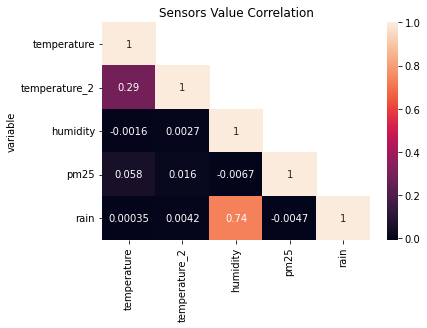

In [36]:
corr_df=corr.set_index('variable')
plt.title('Sensors Value Correlation')
sns.heatmap(corr_df,annot=True);

### Split Data for training and testing

In [8]:
%%sql
DROP TABLE IF EXISTS sensors_split CASCADE;
DROP TABLE IF EXISTS sensors_split_train CASCADE;
DROP TABLE IF EXISTS sensors_split_test CASCADE;

SELECT madlib.train_test_split(
    'sensors_encoded', -- source_table,
    'sensors_split', -- output_table,
    0.7, -- train_proportion,
    NULL, -- test_proportion,
    NULL, -- grouping_cols,
    'temperature,temperature_2,rain,humidity,pm25,
    "month_January","month_February","month_March",
    "month_April","month_May","month_June","month_July",
    "month_August","month_September","month_October",
    "month_November","month_December"', -- target_cols
    FALSE, -- with_replacement,
    TRUE -- separate_output_tables
);

SELECT COUNT(*) as "# In training set" FROM sensors_split_train;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
Done.
Done.
1 rows affected.
1 rows affected.


# In training set
140000


In [88]:
%%sql
SELECT * FROM sensors_split_train LIMIT 5;

 * postgresql://gpadmin@192.168.133.128:32000/db
5 rows affected.


temperature,temperature_2,rain,humidity,pm25,month_January,month_February,month_March,month_April,month_May,month_June,month_July,month_August,month_September,month_October,month_November,month_December
30.0079147791454,43.7874161394457,0,50.8769455862996,72.2157756577628,0,0,0,0,1,0,0,0,0,0,0,0
30.0354904628973,43.4561260855285,0,58.6699979493381,97.7916176662636,0,0,0,0,0,0,0,1,0,0,0,0
30.0388041633031,48.5560429158007,0,52.5095497492418,110.652823406246,0,0,0,0,0,1,0,0,0,0,0,0
30.0388661948235,42.8682580129951,0,56.8999425635809,82.489848383648,0,0,0,0,0,0,0,0,0,0,1,0
30.041992680022,48.6491852514098,1,64.7066467059164,97.9150725439845,0,1,0,0,0,0,0,0,0,0,0,0


In [9]:
train_rain = %sql SELECT COUNT(*) FROM sensors_split_train WHERE rain = 1;
test_rain = %sql SELECT COUNT(*) FROM sensors_split_test WHERE rain = 1;

print("\nTotal rain in training set {}".format(train_rain[0][0]))
print("Total rain in testing set {}".format(test_rain[0][0]))

 * postgresql://gpadmin@192.168.133.128:32000/db
1 rows affected.
 * postgresql://gpadmin@192.168.133.128:32000/db
1 rows affected.

Total rain in training set 35329
Total rain in testing set 15286


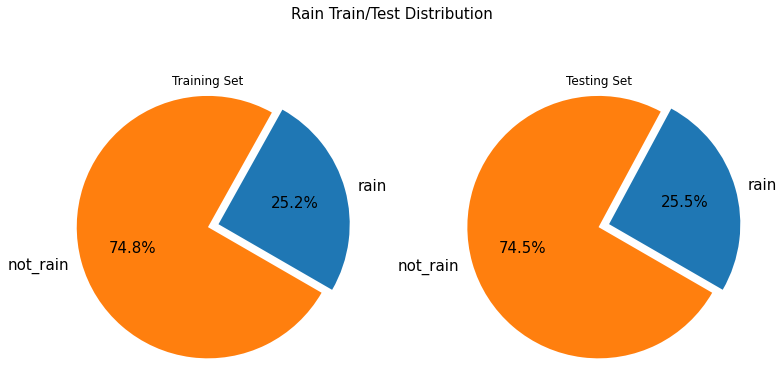

In [11]:
train_data=[train_rain[0][0],int((200000*0.7)-train_rain[0][0])]
test_data=[test_rain[0][0],int((200000*0.3)-test_rain[0][0])]

labels = ['rain','not_rain']

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(11,6))
f.patch.set_facecolor('white')
ax1.title.set_text('Training Set')
ax2.title.set_text('Testing Set')
f.suptitle("Rain Train/Test Distribution",fontsize=15)
ax1.pie(train_data,labels=labels,autopct="%.1f%%",radius=1.2,textprops={'fontsize': 15,},explode = [0.1, 0],startangle = -30);
ax2.pie(test_data,labels=labels,autopct="%.1f%%",radius=1.2,textprops={'fontsize': 15},explode = [0.1, 0], startangle = -30);
plt.tight_layout()

### Classification Model Training ( Logistic Regresion )

In [17]:
%%sql
DROP TABLE IF EXISTS sensors_logreg_model;
DROP TABLE IF EXISTS sensors_logreg_model_summary;

SELECT
    madlib.logregr_train(        -- Train the Logistic Regression Model
        'sensors_split_train',   -- source_table,
        'sensors_logreg_model',  -- out_table,
        'rain',                  -- labels,
        'ARRAY[
            1,
            temperature,
            temperature_2,
            humidity,pm25,
            "month_January","month_February","month_March",
            "month_April","month_May","month_June",
            "month_July","month_August","month_September",
            "month_October","month_November","month_December"]'       -- feature
        --, -- grouping_cols,
        --, -- max_iter,
        --, -- optimizer,
        --, -- tolerance,
        -- verbose
    )
;
SELECT * FROM sensors_logreg_model_summary ;           --- Get the summary table

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
Done.
1 rows affected.
1 rows affected.


method,source_table,out_table,dependent_varname,independent_varname,optimizer_params,num_all_groups,num_failed_groups,num_rows_processed,num_missing_rows_skipped,grouping_col
logregr,sensors_split_train,sensors_logreg_model,rain,"ARRAY[ 1, temperature, temperature_2, humidity,pm25, ""month_January"",""month_February"",""month_March"", ""month_April"",""month_May"",""month_June"", ""month_July"",""month_August"",""month_September"", ""month_October"",""month_November"",""month_December""]","optimizer=irls, max_iter=20, tolerance=0.0001",1,0,140000,0,None


In [19]:
logreg_coefs = %sql SELECT coef FROM sensors_logreg_model ;
logreg_coefs = logreg_coefs.DataFrame();

 * postgresql://gpadmin@192.168.133.128:32000/db
1 rows affected.


In [22]:
logreg_coef_names = (
    'intercept',
    'temperature',
    'temperature_2',
    'humidity',
    'pm25',
    "month_January","month_February","month_March",
    "month_April","month_May","month_June","month_July",
    "month_August","month_September","month_October",
    "month_November","month_December"
)
tuple(zip(logreg_coef_names, logreg_coefs.iloc[0, 0]))

(('intercept', -15357.3971366926),
 ('temperature', -0.330659400026431),
 ('temperature_2', -0.0352642101099704),
 ('humidity', 277.473562503896),
 ('pm25', 0.00836221440637912),
 ('month_January', -1280.07936263549),
 ('month_February', -1279.62007576849),
 ('month_March', -1279.36019451503),
 ('month_April', -1280.01651823909),
 ('month_May', -1279.81121856745),
 ('month_June', -1278.40584862808),
 ('month_July', -1280.20878496331),
 ('month_August', -1278.83340008441),
 ('month_September', -1279.95227289708),
 ('month_October', -1279.2771211395),
 ('month_November', -1279.80808973521),
 ('month_December', -1282.02414832183))

In [29]:
%%sql
DROP TABLE IF EXISTS sensors_logreg_test_prob;
CREATE TABLE sensors_logreg_test_prob
AS
SELECT madlib.logregr_predict_prob(   --- Use the logistic regression model to estimate probability of mature
        coef, 
        ARRAY[
            1,
            temperature,
            temperature_2,
            humidity,
            pm25,
            "month_January","month_February","month_March",
            "month_April","month_May","month_June","month_July",
            "month_August","month_September","month_October",
            "month_November","month_December"]                   
    ) as pred,
    test.rain as y_test
FROM sensors_split_test test, sensors_logreg_model model;

SELECT * FROM sensors_logreg_test_prob LIMIT 10;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
60000 rows affected.
10 rows affected.


pred,y_test
1.0,1
0.0,0
1.0,1
9.48405269040216e-263,0
2.53903929974864e-47,0
0.0,0
0.0,0
0.0,0
0.0,0
1.11541087094126e-268,0


### Confusion Matrix

In [36]:
%%sql
DROP TABLE IF EXISTS sensors_logreg_test_predict ;
CREATE TABLE sensors_logreg_test_predict
AS
SELECT
    (pred >= 0.5)::integer as pred,
    y_test
FROM sensors_logreg_test_prob;


SELECT * FROM sensors_logreg_test_predict LIMIT 10;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
60000 rows affected.
10 rows affected.


pred,y_test
1,1
1,1
0,0
0,0
1,1
0,0
0,0
0,0
0,0
0,0


In [81]:
%%sql
DROP TABLE IF EXISTS sensors_logreg_test_conf_matrix;
SELECT
madlib.confusion_matrix(
    'sensors_logreg_test_predict',
    'sensors_logreg_test_conf_matrix',
    'pred',  -- prediction_col
    'y_test' -- observation_col
);

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
1 rows affected.


confusion_matrix
""


In [82]:
confusion = %sql SELECT \
                        confusion_arr[1] as "Predicted 0",\
                        confusion_arr[2] as "Predicted 1" \
                        FROM sensors_logreg_test_conf_matrix ORDER BY row_id;

confusion=confusion.DataFrame()

 * postgresql://gpadmin@192.168.133.128:32000/db
2 rows affected.


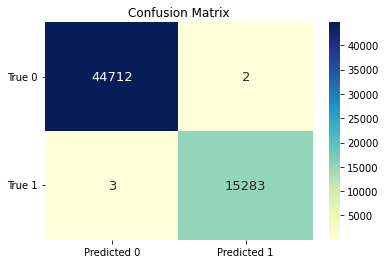

In [83]:
plt.title('Confusion Matrix')
sns.heatmap(confusion.astype(int),annot=True,cmap="YlGnBu",fmt='d',yticklabels=['True 0','True 1'],annot_kws={"fontsize":13});
plt.yticks(rotation=0);

### ROC

In [84]:
%%sql
DROP TABLE IF EXISTS sensors_logreg_test_auc;
SELECT
madlib.area_under_roc(
    'sensors_logreg_test_prob', 
    'sensors_logreg_test_auc', 
    'pred',  -- predictions, 
    'y_test'
);

SELECT * FROM sensors_logreg_test_auc;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
1 rows affected.
1 rows affected.


area_under_roc
0.999999970738767296014724484081160804337672330


### Linear Regression

In [86]:
%%sql
DROP TABLE IF EXISTS sensors_linreg_model;
DROP TABLE IF EXISTS sensors_linreg_model_summary;

SELECT madlib.linregr_train(
    'sensors_split_train',   -- source_table
    'sensors_linreg_model',  -- out_table
    'temperature_2',         -- labels
    'ARRAY[
        1,
        temperature,
        humidity,pm25,
        "month_January","month_February","month_March",
        "month_April","month_May","month_June",
        "month_July","month_August","month_September",
        "month_October","month_November","month_December"]',       -- feature
    NULL,  -- grouping_cols
    TRUE  -- heteroskedasticity_option
);

SELECT * FROM sensors_linreg_model LIMIT 10;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
Done.
1 rows affected.
1 rows affected.


[([13.8290569608607, 1.00132120330787, 0.000620070224672656, -0.000687837245387593, 1.14242185777278, 1.15870975767609, 1.14047218639094, 1.13590546107977, 1.16595450670519, 1.20515870590621, 1.12360198366909, 1.19741490116385, 1.10379848248854, 1.16458210315074, 1.11064610831375, 1.18039090647682], 0.0852803991462855, [0.262153408175241, 0.0087782631885164, 0.000534151110961869, 0.000524850433127062, 0.0343288570600741, 0.0354442981680279, 0.0344342756822038, 0.0343 ... (22 characters truncated) ... 7220765735, 0.0343348401210223, 0.0341770344654323, 0.0340348775472282, 0.034569934656514, 0.0342216442640082, 0.0344364018464563, 0.0341855106823175], [52.7517725484478, 114.068259495544, 1.16085169898097, -1.31053954035906, 33.2787618234299, 32.6910058194152, 33.1202606645899, 33.0303866355656, 34.230638840985, 35.1001694389227, 32.8759355878445, 35.1819952782926, 31.9294350265874, 34.0305712421762, 32.2520951307823, 34.5289826864393], [0.0, 0.0, 0.245704193881602, 0.190015527233267, 6.95093191252978e-242, 1.60125935920798e-233, 1.29291573557814e-239, 2.47581032811364e-238, 9.7403626 ... (24 characters truncated) ... 516859e-269, 3.88262479743245e-236, 5.74884009365129e-270, 6.63685866749574e-223, 8.55400304233653e-253, 2.25743086171718e-227, 3.69472395532367e-260], 20799188760.8535, 18.9536419697099, 0.215842295899762, 140000, 0, [[0.0687244094178944, -0.00225412214306021, -1.36303799947794e-05, -1.66011200034094e-05, 0.00572267351493218, 0.00572486249149746, 0.0057494079175667 ... (5372 characters truncated) ... 000412621658025562, 0.000418659338743826, 0.000419003739905476, 0.000420538217990173, 0.000421389067215399, 0.00041775048681284, 0.00116864914061084]])]

In [92]:
%%sql
DROP TABLE IF EXISTS sensors_linreg_test_predict;

CREATE TABLE sensors_linreg_test_predict
AS
SELECT 
    madlib.linregr_predict(
        coef, 
        ARRAY[
            1,
            temperature,
            humidity,pm25,
            "month_January","month_February","month_March",
            "month_April","month_May","month_June",
            "month_July","month_August","month_September",
            "month_October","month_November","month_December"
            ] 
    ) as prediction,
    test.temperature_2 as y_test
FROM sensors_split_test test, sensors_linreg_model model;

SELECT * FROM sensors_linreg_test_predict LIMIT 5;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
60000 rows affected.
5 rows affected.


prediction,y_test
47.9130473211639,50.998211798989
47.246891685789,45.46335266306
48.3954603823764,43.5931287800048
45.813928129998,51.0824590280718
48.3401670475287,53.152989600203


In [94]:
%%sql
DROP TABLE IF EXISTS sensors_linreg_test_predict_mse;

SELECT madlib.mean_squared_error(
    'sensors_linreg_test_predict',      -- table_in
    'sensors_linreg_test_predict_mse',  -- table_out
    'prediction',  -- prediction
    'y_test'  -- y_test
);

SELECT * FROM sensors_linreg_test_predict_mse;

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
1 rows affected.
1 rows affected.


mean_squared_error
9.02218796790964


In [145]:
pred = %sql SELECT * FROM sensors_linreg_test_predict LIMIT 200;
pred=pred.DataFrame()

 * postgresql://gpadmin@192.168.133.128:32000/db
200 rows affected.


In [146]:
pred

,prediction,y_test
0,48.011237,50.484969
1,46.782641,43.559589
2,47.255168,52.312498
3,48.008168,45.144718
4,45.975739,42.139974
...,...,...
195,46.620444,49.780645
196,46.088552,43.951122
197,47.363575,42.385181
198,47.593380,45.062676


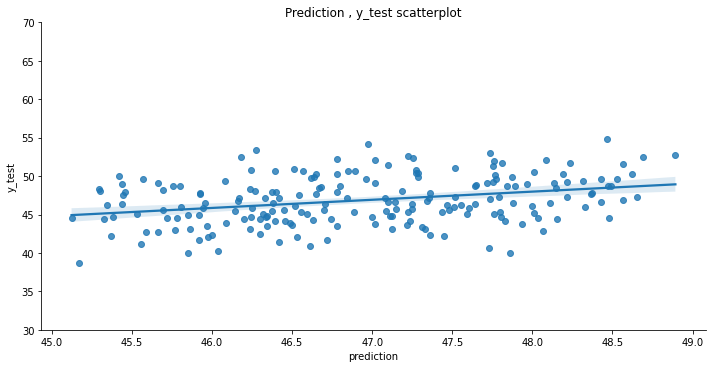

In [152]:
sns.lmplot(x='prediction',y='y_test',data=pred,height=5,aspect=2)
plt.title("Prediction , y_test scatterplot") 
plt.ylim(30,70);
